## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import imblearn

# from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression

## Hyperparameters and Directories

In [2]:
data = 'Pokemon.csv'

SEED = 42
ITERATIONS = 1000
LEARNING_RATE = 10

## Data Loading and Pre-processing

### Import dataset

In [3]:
df = pd.read_csv('Pokemon.csv')

## Exploratory data analysis

In [4]:
print(f"Found {df.shape[0]} samples with {df.shape[1]} features")

Found 800 samples with 13 features


#### Let's preview the dataset

In [5]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


#### Now let's view the columns

In [6]:
col_names = df.columns

col_names

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

#### Check distribution of target_class column

In [7]:
df['Legendary'].value_counts()

Legendary
False    735
True      65
Name: count, dtype: int64

#### View summary of the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


#### Check of missing value

In [9]:
df.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Type 2 missing is normal, not all pokemon has secondary type

### Remove unused features

In [10]:
# df.drop(columns=['#', 'Name', 'Type 1', 'Type 2'],inplace=True)
df.drop(columns=['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation'],inplace=True)

df

,Total,Legendary
0,318,False
1,405,False
2,525,False
3,625,False
4,309,False
...,...,...
795,600,True
796,700,True
797,600,True
798,680,True


### Turn boolean to int

In [11]:
df['Legendary'] = df['Legendary'].astype(int)
df

,Total,Legendary
0,318,0
1,405,0
2,525,0
3,625,0
4,309,0
...,...,...
795,600,1
796,700,1
797,600,1
798,680,1


### Just removing pseudo pokemon

In [12]:
df = df[~((df['Legendary'] & (df['Total'] < 600)) | (~df['Legendary'] & (df['Total'] >= 600)))]


### Declare feature vector and target variable

In [13]:
X = df.drop('Legendary', axis=1)  # Drop the target column from features
y = df['Legendary']  # Target column containing labels

### Split data into separate training and test set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

### Undersampling

In [15]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [16]:
# ros = imblearn.over_sampling.RandomOverSampler(random_state=42)
# X_train, y_train = ros.fit_resample(X_train, y_train)

In [17]:
X_train

,Total
26,262
159,300
560,308
511,594
181,250
...,...
427,600
543,670
711,700
163,780


In [18]:
y_train.value_counts()

Legendary
0    37
1    37
Name: count, dtype: int64

In [19]:
X_test

,Total
68,310
492,410
17,205
756,288
145,525
...,...
566,370
348,460
798,680
435,309


In [20]:
y_test

68     0
492    0
17     0
756    0
145    0
      ..
566    0
348    0
798    1
435    0
670    0
Name: Legendary, Length: 149, dtype: int64

## Training

### Function and Class

In [21]:
class LogisticRegression:
    # Class constructor
    def __init__(self, alpha=1, iteration=1500):
        self.w = None # Weights
        self.n = None # No. of samples
        self.b = 0
        self.X = None
        self.y = None
        # Define the learning rate
        self.alpha = alpha
        # Define the iteration number
        self.iteration = iteration

    def sigmoid(self, z):
        # print(f"z = {z}")
        return 1 / (1 + 1 / np.exp(z))

    # Class function to fit the data (find the appropiate value of w)
    def fit(self, X, y):
        self.X = X
        self.y = y

        # Number of samples & number of features (dimensions)
        self.n, d = X.shape
        print(X.shape)

        # Initialize w
        self.w = np.zeros(d)

        # Gradient Descent
        for i in range(self.iteration):
            print(f"Epoch {i+1}/{self.iteration}")
            # Decrease learning rate when overshot
            if not self.make_one_update():
                self.alpha *= 0.1

    def make_one_update(self):
        w_current = self.w
        b_current = self.b  

        # Compute gradients
        dw, db = self.compute_gradient(w_current, b_current)
        # print(dw, db)       
        step_w = (-1) * self.alpha * dw
        step_b = (-1) * self.alpha * db
        # print(step_b)

        # Update weights and bias
        w_update = w_current + step_w
        b_update = b_current + step_b

        current_loss = self.log_loss(w_current, b_current)
        update_loss = self.log_loss(w_update, b_update)
        
        if current_loss > update_loss:
            print("Loss decreases to ", update_loss)
            self.w = w_update
            self.b = b_update
            return True
        else:
            print("Loss increases to ", update_loss)
            return False

    def compute_gradient(self, w_current, b_current):
        z = np.dot(self.X, w_current) + b_current
        # Apply sigmoid function
        y_prob = self.sigmoid(z)

        # Compute gradients
        dw = (1 / self.n) * np.dot(self.X.transpose(), (y_prob - self.y))
        db = (1 / self.n) * np.sum(y_prob - self.y)

        return dw, db
    
    def log_loss(self, w, b):
        e = 1e-5
        z = np.dot(self.X, w) + b
        y_prob = self.sigmoid(z) + e
        loss = (-1 / self.n) * np.sum(self.y * np.log(y_prob)           # if y = 1
                              + (1 - self.y) * np.log(1 - y_prob))      # if y = 0
        return loss

    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        y_pred = self.sigmoid(z)
        y_pred_class = [1 if i >= 0.5 else 0 for i in y_pred]
        return np.array(y_pred_class)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

    def probability_curve(self, X):
        z = np.dot(X, self.w) + self.b
        y_predicted = self.sigmoid(z)
        return y_predicted

### Prediction

In [22]:
h = LogisticRegression(alpha=LEARNING_RATE, iteration=ITERATIONS)
h.fit(X_train, y_train)
# y_pred = h.predict(X_test)

(74, 1)
Epoch 1/1000
Loss decreases to  -0.0
Epoch 2/1000
Loss increases to  5.7564677325101155
Epoch 3/1000
Loss increases to  -0.0
Epoch 4/1000
Loss increases to  -0.0
Epoch 5/1000
Loss increases to  -0.0
Epoch 6/1000
Loss increases to  -0.0
Epoch 7/1000
Loss increases to  -0.0
Epoch 8/1000
Loss increases to  -0.0
Epoch 9/1000
Loss increases to  -0.0
Epoch 10/1000
Loss increases to  -0.0
Epoch 11/1000
Loss increases to  -0.0
Epoch 12/1000
Loss increases to  -0.0
Epoch 13/1000
Loss increases to  -0.0
Epoch 14/1000
Loss increases to  -0.0
Epoch 15/1000
Loss increases to  -0.0
Epoch 16/1000
Loss increases to  -0.0
Epoch 17/1000
Loss increases to  -0.0
Epoch 18/1000
Loss increases to  -0.0
Epoch 19/1000
Loss increases to  -0.0
Epoch 20/1000
Loss increases to  -0.0
Epoch 21/1000
Loss increases to  -0.0
Epoch 22/1000
Loss increases to  -0.0
Epoch 23/1000
Loss increases to  -0.0
Epoch 24/1000
Loss increases to  -0.0
Epoch 25/1000
Loss increases to  -0.0
Epoch 26/1000
Loss increases to  -0.0

Loss increases to  -0.0
Epoch 320/1000
Loss increases to  -0.0
Epoch 321/1000
Loss increases to  -0.0
Epoch 322/1000
Loss increases to  -0.0
Epoch 323/1000
Loss increases to  -0.0
Epoch 324/1000
Loss increases to  -0.0
Epoch 325/1000
Loss increases to  -0.0
Epoch 326/1000
Loss increases to  -0.0
Epoch 327/1000
Loss increases to  -0.0
Epoch 328/1000
Loss increases to  -0.0
Epoch 329/1000
Loss increases to  -0.0
Epoch 330/1000
Loss increases to  -0.0
Epoch 331/1000
Loss increases to  -0.0
Epoch 332/1000
Loss increases to  -0.0
Epoch 333/1000
Loss increases to  -0.0
Epoch 334/1000
Loss increases to  -0.0
Epoch 335/1000
Loss increases to  -0.0
Epoch 336/1000
Loss increases to  -0.0
Epoch 337/1000
Loss increases to  -0.0
Epoch 338/1000
Loss increases to  -0.0
Epoch 339/1000
Loss increases to  -0.0
Epoch 340/1000
Loss increases to  -0.0
Epoch 341/1000
Loss increases to  -0.0
Epoch 342/1000
Loss increases to  -0.0
Epoch 343/1000
Loss increases to  -0.0
Epoch 344/1000
Loss increases to  -0.0
E

/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + 1 / np.exp(z))
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:80: RuntimeWarning: invalid value encountered in log
  + (1 - self.y) * np.log(1 - y_prob))      # if y = 0
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + 1 / np.exp(z))
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + 1 / np.exp(z))
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:80: RuntimeWarning: invalid value encountered in log
  + (1 - self.y) * np.log(1 - y_prob))      # if y = 0
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:16: RuntimeWarning: divide by zero encountered in divide
  return 1

Loss increases to  -0.0
Epoch 799/1000
Loss increases to  -0.0
Epoch 800/1000
Loss increases to  -0.0
Epoch 801/1000
Loss increases to  -0.0
Epoch 802/1000
Loss increases to  -0.0
Epoch 803/1000
Loss increases to  -0.0
Epoch 804/1000
Loss increases to  -0.0
Epoch 805/1000
Loss increases to  -0.0
Epoch 806/1000
Loss increases to  -0.0
Epoch 807/1000
Loss increases to  -0.0
Epoch 808/1000
Loss increases to  -0.0
Epoch 809/1000
Loss increases to  -0.0
Epoch 810/1000
Loss increases to  -0.0
Epoch 811/1000
Loss increases to  -0.0
Epoch 812/1000
Loss increases to  -0.0
Epoch 813/1000
Loss increases to  -0.0
Epoch 814/1000
Loss increases to  -0.0
Epoch 815/1000
Loss increases to  -0.0
Epoch 816/1000
Loss increases to  -0.0
Epoch 817/1000
Loss increases to  -0.0
Epoch 818/1000
Loss increases to  -0.0
Epoch 819/1000
Loss increases to  -0.0
Epoch 820/1000
Loss increases to  -0.0
Epoch 821/1000
Loss increases to  -0.0
Epoch 822/1000
Loss increases to  -0.0
Epoch 823/1000
Loss increases to  -0.0
E

/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:80: RuntimeWarning: invalid value encountered in log
  + (1 - self.y) * np.log(1 - y_prob))      # if y = 0
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + 1 / np.exp(z))
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + 1 / np.exp(z))
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:80: RuntimeWarning: invalid value encountered in log
  + (1 - self.y) * np.log(1 - y_prob))      # if y = 0
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + 1 / np.exp(z))
/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:80: RuntimeWarning: invalid value encountered in log
  + (1 - self.

### Evaluation

In [23]:
score = round(h.score(X_test, y_test)*100, 2)
print("The accuracy score we have achieved using Logistic Regression is: "+str(score)+" %")

The accuracy score we have achieved using Logistic Regression is: 6.04 %


/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + 1 / np.exp(z))


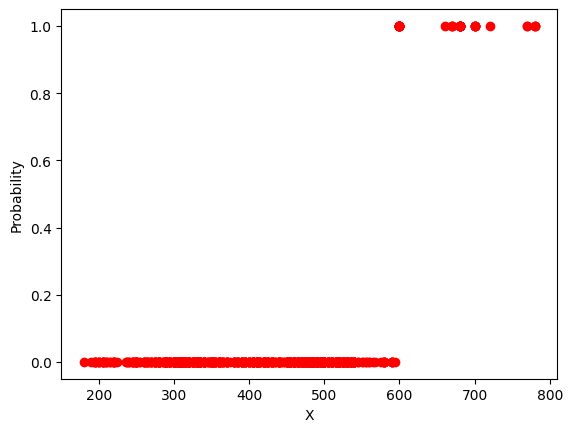

In [24]:
plt.plot(X, y, 'ro')
plt.xlabel('X')
plt.ylabel('Probability')
plt.show()

In [25]:
h.w

array([659.59459459])

In [26]:
h.b

0.0

/var/folders/dp/xf02s8yx7yj7k0h2v83wcq2m0000gn/T/ipykernel_82689/2141390107.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + 1 / np.exp(z))


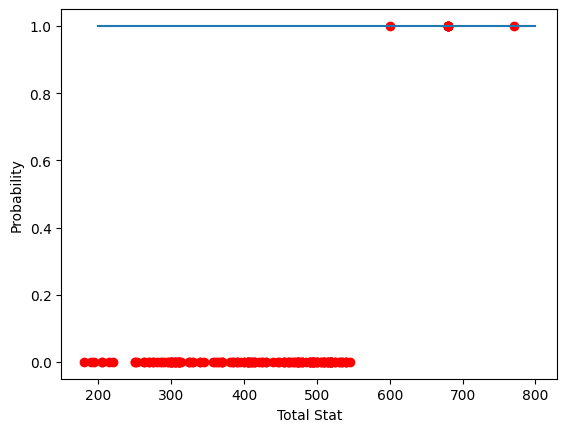

In [27]:
# Plot the probability curve
plt.plot(X_test, y_test, 'ro')
plt.plot(np.array([np.arange(start=200, stop=800, step=1)]).T, h.probability_curve(np.array([np.arange(start=200, stop=800, step=1)]).T))
plt.xlabel('Total Stat')
plt.ylabel('Probability')
plt.show()